In [18]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
DATA_FOLDER = "../figure_3/data/"
SCRNASEQ_DATA_FOLDER = "../../../data/"

height_ratios_scaling: [1, 1, 1]


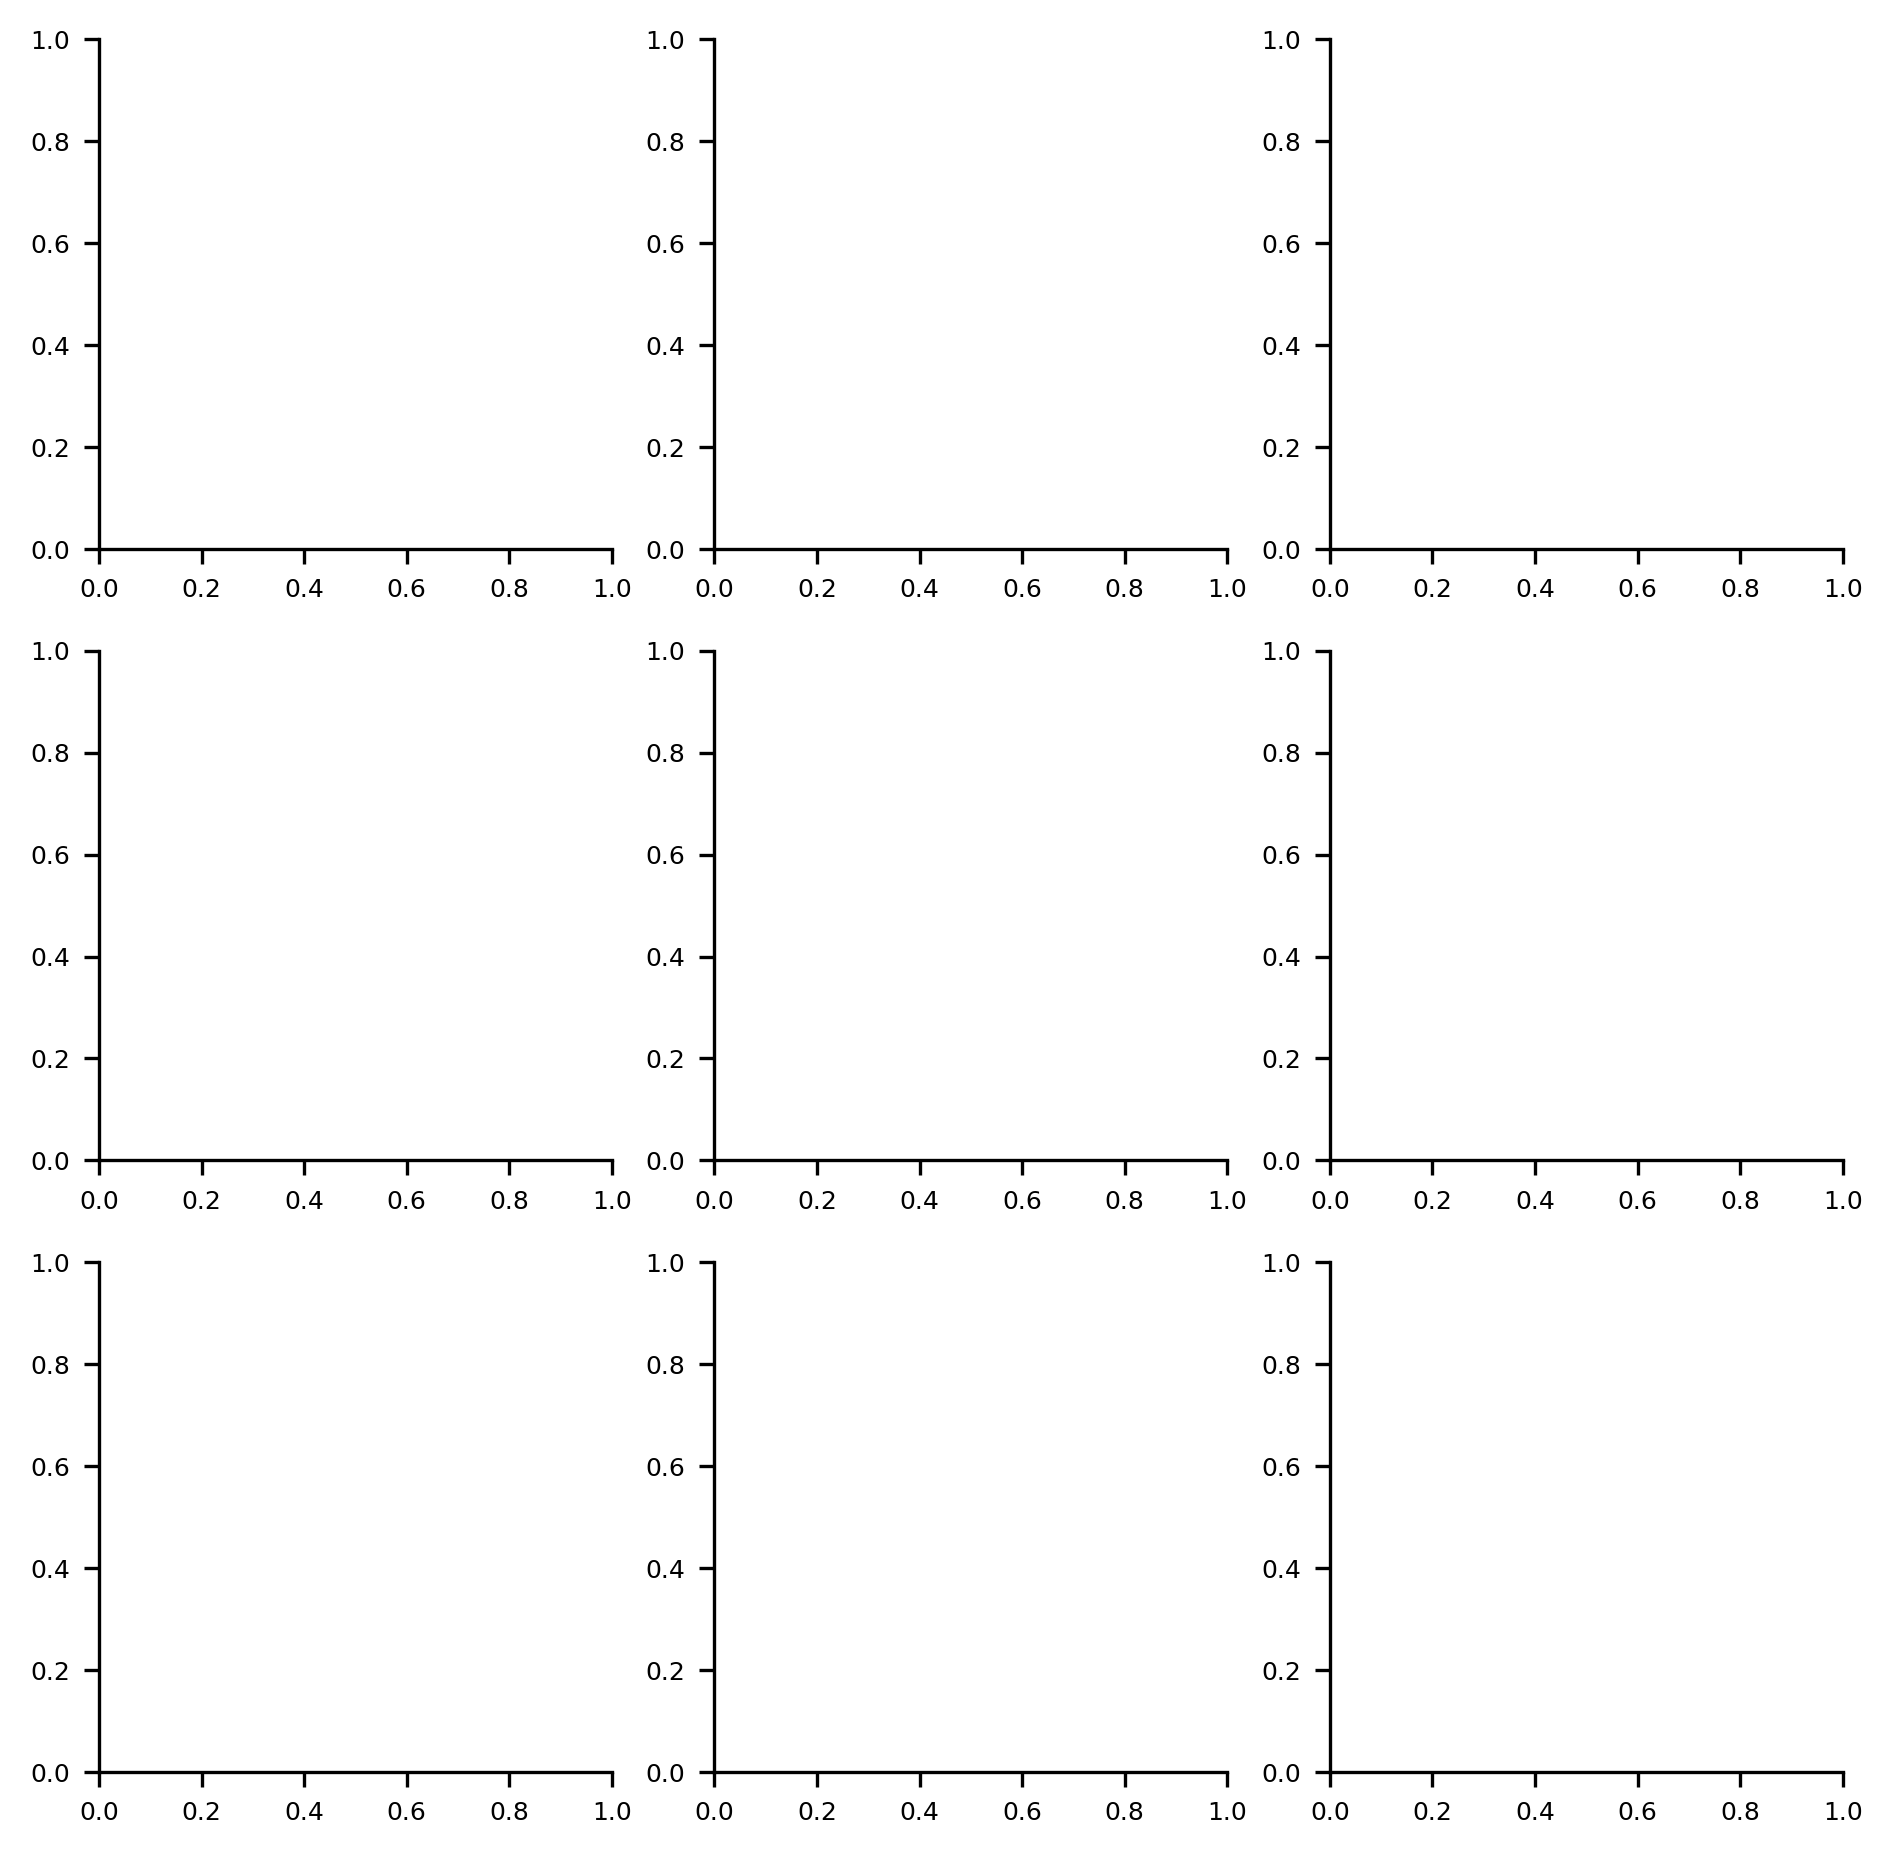

In [21]:
mosaic = [["A", "B", "C"], ["D", "E", "F"], ["G", "H", "I"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [22]:
breast_cancer = pickle.load(
    open(os.path.join(DATA_FOLDER, "breast_cancer_results.pkl"), "rb")
)
breast_cancer

{'z_space_embedding': array([[ 13.453772  ,   1.8798009 ],
        [ 15.209827  ,   1.0762023 ],
        [ 14.123289  ,   0.51939666],
        ...,
        [ -9.553252  ,  -2.6086369 ],
        [ -9.898246  ,  -3.035167  ],
        [-10.406434  ,  -2.9625492 ]], dtype=float32),
 'inferred_theta': array([ 0.15582252,  0.29155588,  1.3966305 , ..., -1.2312727 ,
        -1.3223536 , -1.6453419 ], dtype=float32),
 'cycling_cells': array([ True,  True,  True, ..., False,  True, False]),
 'latent_z': array([[ 0.37332025,  2.5333421 , -0.46433154, ...,  1.718476  ,
         -0.9878677 , -0.3008021 ],
        [ 0.85030633,  3.3389647 , -1.3104458 , ...,  1.7666677 ,
         -0.95434105,  0.33655956],
        [ 0.8152305 ,  3.4553273 , -0.7615098 , ...,  1.5899904 ,
         -1.4149601 ,  0.08895269],
        ...,
        [ 0.59145766,  2.1623764 , -1.5544022 , ...,  1.7311082 ,
          0.08773069,  2.0144174 ],
        [ 0.13439658,  2.4320266 , -1.5418478 , ...,  1.6831615 ,
         -0.68

In [23]:
adata = breast_cancer["adata"]

In [24]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fraction(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    genes_fraction = (
        adata[:, gene_names].layers[layer].toarray().sum(axis=1) / library_size
    )
    return genes_fraction


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="total",
    hue=None,
    phase_label="Inferred",
    legend_title=None,
):
    axs = plot_helpers.replace_mosaic_cell_with_grid(
        fig, axs, label=position, nrows=1, ncols=len(gene_names)
    )
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(
            ax=axs[position][i], axis="x", step=0.5
        )
        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            title=f"{gene_name} Profile",
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)

In [26]:
ax = axs["A"]
cycling_status = breast_cancer["cycling_cells"]
plotting.modify_axis_labels(ax=ax, step=0.5)
sns.histplot(breast_cancer["inferred_theta"][~cycling_status], ax=ax)
ax.set_xlabel("Inferred Phase")
ax.set_title("Non-cycling Cells Phases")

Text(0.5, 1.0, 'Non-cycling Cells Phases')

In [27]:
ax = axs["B"]
plotting.modify_axis_labels(ax=ax, step=0.5)
sns.histplot(
    x=breast_cancer["inferred_theta"][cycling_status],
    ax=ax,
    hue=adata[cycling_status].obs["cycling"],
)
ax.set_xlabel("Inferred Phase")
ax.set_title("Original Annotation Phases")

Text(0.5, 1.0, 'Original Annotation Phases')

In [28]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, y_true, y_pred, title="Cycling Cells"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    # divide by row sums to get fractions
    cm = cm.astype("float") / cm.sum()

    # Rows are true labels, columns are predicted labels:
    # [[TP, FN],
    #  [FP, TN]]

    ax.imshow(cm, interpolation="nearest")

    ax.set(
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=["True", "False"],
        yticklabels=["True", "False"],
        ylabel="Predicted label",
        xlabel="Original label",
        title=title,
    )

    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                f"{cm[i, j]*100:.0f}%",
                ha="center",
                va="center",
                color="white" if cm[i, j] < cm.max() / 2 else "black",
            )

    return ax


ax = axs["C"]
# ax = plt.gca()
plot_confusion_matrix(ax, cycling_status, adata.obs["cycling"])

<Axes: label='C', title={'center': 'Cycling Cells'}, xlabel='Original label', ylabel='Predicted label'>

In [29]:
def plot_ig(ig_dict, subtype, ax):
    ig = ig_dict[subtype]
    ig = ig.sort_values()
    sns.barplot(
        y=ig.iloc[:10].index.tolist() + ig.iloc[-5:].index.tolist(),
        x=ig.iloc[:10].values.tolist() + ig.iloc[-5:].values.tolist(),
        hue=["neg"] * 10 + ["pos"] * 5,
        legend=False,
        ax=ax,
    )
    ax.set_title(f"{subtype} Integrated Gradients")
    ax.set_xlabel("IG Value")
    plt.setp(ax.get_yticklabels(), fontstyle="italic")


for ax_key, subtype in zip("DEF", breast_cancer["integrated_gradients"].keys()):
    ax = axs[ax_key]
    plot_ig(breast_cancer["integrated_gradients"], subtype, ax)

In [30]:
g1_g0_cells = (breast_cancer["inferred_theta"] >= -0.7 * np.pi) & (
    breast_cancer["inferred_theta"] <= -0.4 * np.pi
)
ax = axs["G"]
logits = breast_cancer["logits"]
sns.ecdfplot(
    x=logits[g1_g0_cells],
    ax=ax,
    hue=adata.obs["orig.ident"][g1_g0_cells].rename("Subtype"),
    complementary=True,
    log_scale=(False, True),
)
ax.set_xlabel("Cycling Logits")
ax.set_ylabel("Density")
ax.set_title("G1/G0 Cells Cycling Logits")

Text(0.5, 1.0, 'G1/G0 Cells Cycling Logits')

In [31]:
from CoPhaser import gene_sets


def plot_gene_differences(genes, ax, title="", legend_location="best"):
    weights = 1 / (1 + np.exp(-logits[g1_g0_cells]))
    if len(genes) == 1:
        expr = get_gene_fractions(genes[0], adata[g1_g0_cells])
    else:
        expr = get_genes_fraction(genes, adata[g1_g0_cells])
    expr = np.log(expr * 1e4 + 1)
    means = {}
    for subtype in adata.obs["orig.ident"].unique():
        subtype_cells = adata.obs["orig.ident"][g1_g0_cells] == subtype
        subtype_weights = weights[subtype_cells]
        subtype_expr = expr[subtype_cells]
        means[subtype] = {
            "True": np.average(subtype_expr, weights=subtype_weights),
            "False": np.average(subtype_expr, weights=1 - subtype_weights),
        }
    df_means = pd.DataFrame(means).T.reset_index().melt(id_vars="index")
    df_means.columns = ["Subtype", "Cycling Status", "Mean Expression"]
    sns.barplot(
        x="Subtype",
        y="Mean Expression",
        hue="Cycling Status",
        data=df_means,
        errorbar=None,
        ax=ax,
    )
    ax.set_ylabel(f"Normalized Counts (log)")
    ax.set_title(f"{title} Mean Expression")
    ax.legend(loc=legend_location, title="Cycling Pred.")


plot_gene_differences(["BIRC5"], axs["H"], title="")
axs["H"].set_title("BIRC5", fontweight="bold", style="italic")
ccg = [
    gene.upper()
    for gene in gene_sets.SMALL_CELL_CYCLE_GENE_SET
    if gene.upper() in adata.var_names
]
plot_gene_differences(ccg, axs["I"], title="CCGs", legend_location="lower right")

Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S6_bc_classifier_analysis.svg


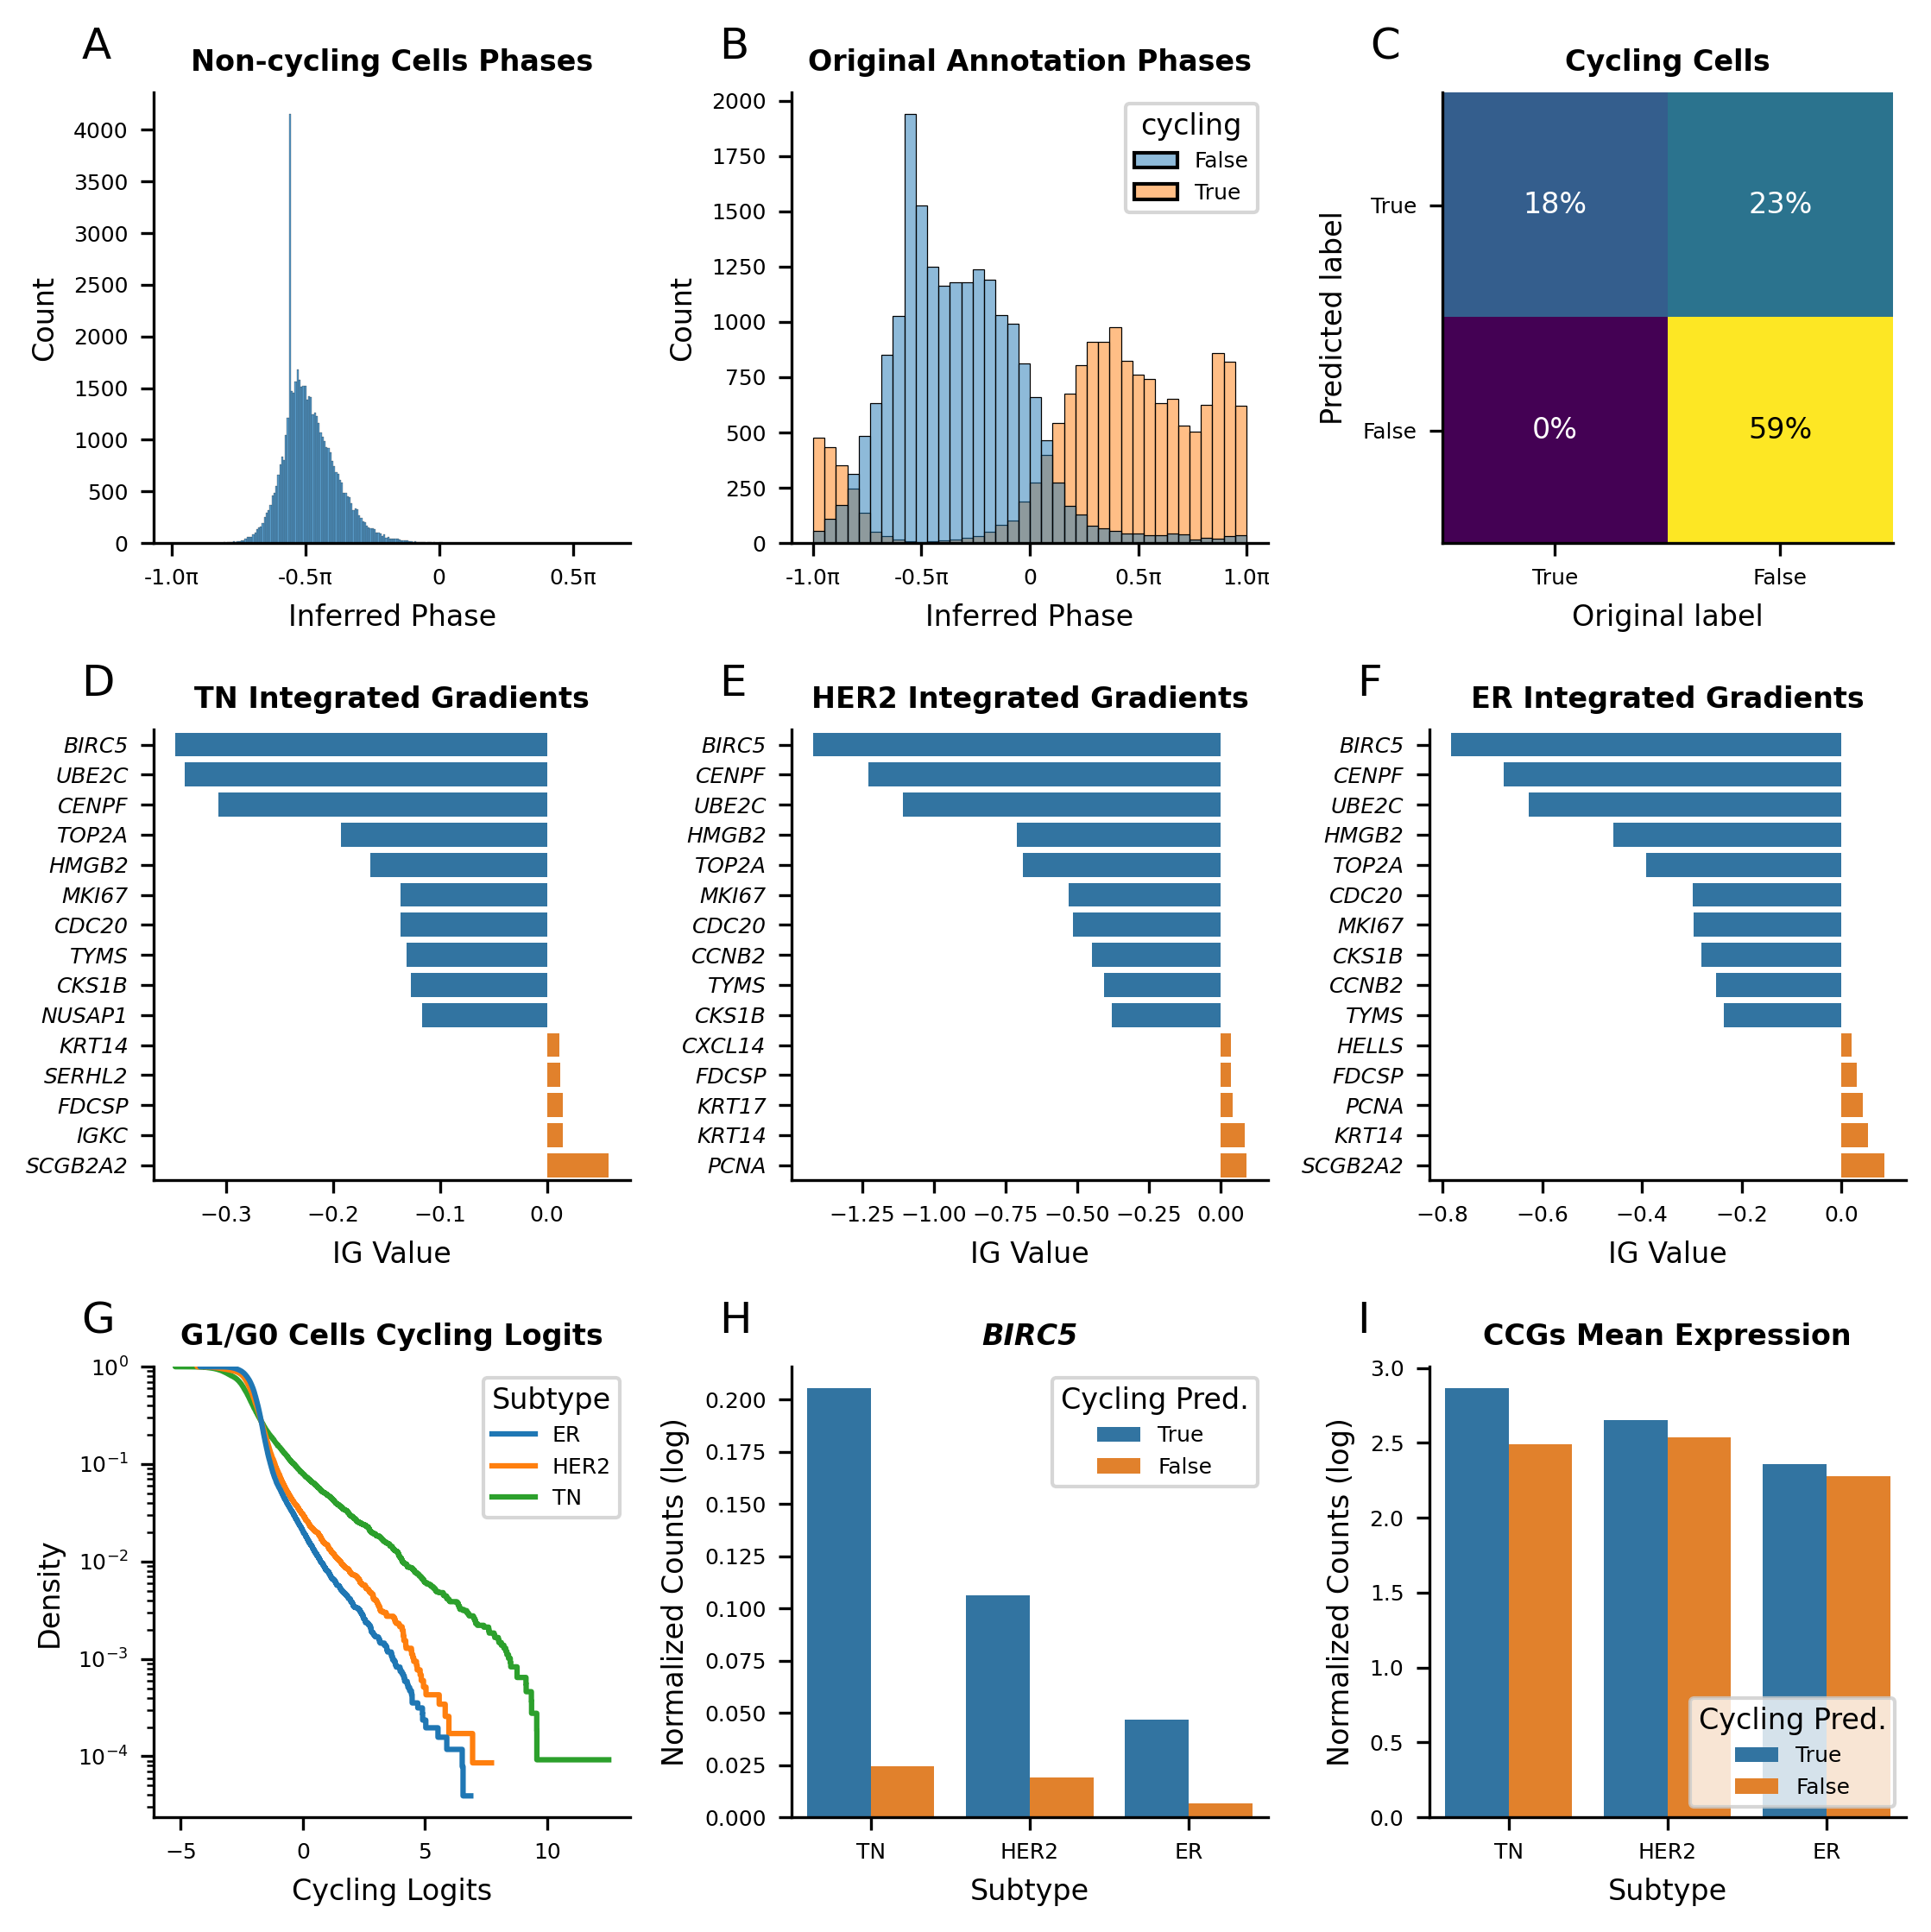

In [ ]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic=mosaic)
plot_helpers.save_figure(fig, axs, "figure_S5_bc_classifier_analysis")